In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.table import QTable

# Tabla de miembros:

In [2]:
members = QTable.read('./../data/raw/members.fit')
members = members.to_pandas()

# Tabla de clusters:

In [3]:
clusters = QTable.read('./../data/raw/clusters.fit')
clusters = clusters.to_pandas()
clusters = clusters.sort_values(by='N', ascending=False)

# Tabla de distancias

Esta tabla es recuperada de la tabla `external.gaiaedr3_distance`, donde las distancias son dadas en $\text{pc}$.

In [4]:
distance_members = QTable.read('./../data/raw/distances.fits')
distance_members = distance_members.to_pandas()

# Datos pedidos

La tabla de cúmulos se organizó de mayor a menor número de miembros. El `.iloc` escoge el cúmulo que es la fila $i$, y la ascensión recta y la declinación que son las columnas 3 y 4 de la tabla. 

Según el catálogo este es el punto más denso del cúmulo.

In [5]:
ra0 = clusters.iloc[1, 3]
dec0 = clusters.iloc[1, 4]

## Recolección de datos pedidos

Se crea una tabla con todos los datos del respectivo cúmulo:

In [14]:
cluster_members = members[members['Name'] == clusters.iloc[1, 0]]

Se agrega las distancias de cada respectiva estrella a la anterior tabla:

In [15]:
cluster_members = pd.merge(cluster_members, distance_members[['GaiaDR3', 'r_med_geo']], how='left', on='GaiaDR3')

## Figura del cúmulo

Text(0, 0.5, 'Dec [deg]')

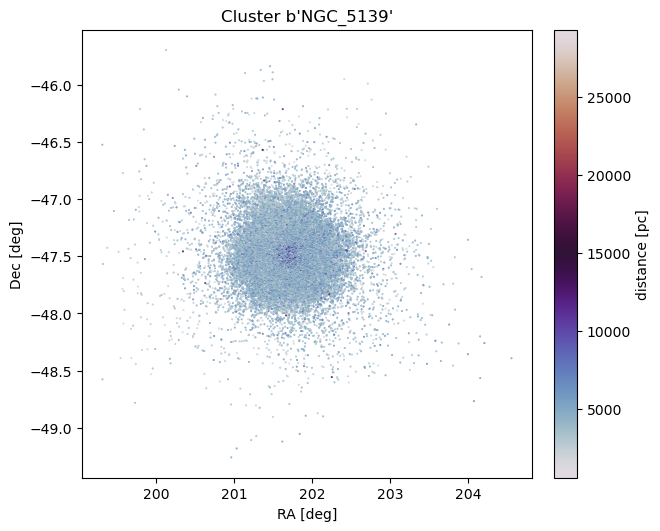

In [19]:
fig, ax = plt.subplots(figsize=(6.5, 5.2), constrained_layout=True)
cs = ax.scatter(
    cluster_members['RA_ICRS'],
    cluster_members['DE_ICRS'],
    c = cluster_members['r_med_geo'],
    s=0.2,
    vmin=min(cluster_members['r_med_geo']),
    vmax=max(cluster_members['r_med_geo']),
    cmap='twilight',
)

cb = fig.colorbar(cs)
cb.set_label("distance [pc]")

ax.set_title(f"Cluster {cluster_members['Name'][0]}")
ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")

# Cálculo de la densidad de área del cúmulo

Se calcula la distancia de los miembros al punto más denso del cúmulo usando la siguiente fórmula: $$\cos{c} = \cos{a}\cos{b} + \sin{a}\sin{b}\cos{C}$$ donde $c$ sería la distancia que se quiere encontrar.

Para usar esta fórmula se debe hacer la respectiva geometría esférica en la bóveda celeste.

In [20]:
a = np.deg2rad(90 - dec0)
b = np.deg2rad(90 - cluster_members['DE_ICRS'])
C = np.deg2rad(ra0 - cluster_members['RA_ICRS'])

cosc = np.cos(a)*np.cos(b) + np.sin(a)*np.sin(b)*np.cos(C)
c = np.arccos(cosc)

cluster_distance_members = np.rad2deg(c)

Se crea un dataframe para concatenarlo a la tabla de miembros del cúmulo:

In [21]:
d_members = pd.DataFrame(
    {'d_members': cluster_distance_members}
)

Se halla la máxima distancia:

In [22]:
d_max = max(cluster_distance_members)

Se generan los radios hasta la distancia máxima para calcular la densidad de área por anillos:

In [23]:
rs = np.linspace(0, d_max, 50)

In [24]:
# calcula los radios medios de cada anillo
def mean_radii(radii):
    return (radii[1:] + radii[:-1])/2

# calcula el área de cada anillo
def ring_areas(radii):
    area0 = np.pi * radii[:-1]**2
    area1 = np.pi * radii[1:]**2
    return area1 - area0

# calcula la densidad de número de miembros en cada anillo
def ring_densities(areas, distances, radii):
    counts = np.zeros(len(areas))
    for i in range(len(radii)-1):
        count = 0
        for j in range(len(distances)):
            if radii[i] < distances[j] and distances[j] <= radii[i+1]:
                count += 1
        counts[i] = count
    return counts/areas

# calcula el respectivo dato pedido de los miembros en cada anillo
def data(name, radii, distances, data_frame):
    mean_data = np.zeros(len(radii)-1)
    for i in range(len(radii)-1):
        data_ = []
        for j in range(len(distances)):
            if radii[i] < distances[j] and distances[j] <= radii[i+1]:
                data_.append(data_frame[name][i].value)
        mean_data[i] = np.mean(data_)
    return mean_data

# Densidad de número por cada anillo

In [25]:
radii = mean_radii(rs)
areas = ring_areas(rs)
densities = ring_densities(areas, cluster_distance_members, rs)

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


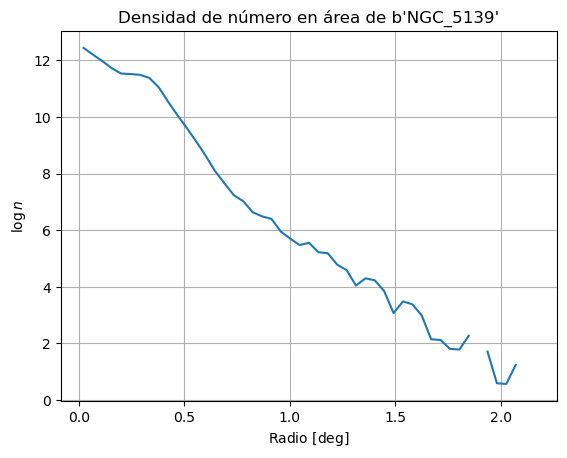

In [27]:
plt.plot(radii, np.log(densities))
plt.title(f"Densidad de número en área de {cluster_members['Name'][0]}")
plt.xlabel(r"Radio $[$deg$]$")
plt.ylabel(r'$\log{n}$')
plt.grid(True)
plt.show()

---
Se concatena la distancia de los miembros del cúmulo al punto más denso de este, a la tabla `cluster_members`, esto para poder calcular los datos pedidos de las estrellas en cada anillo.

In [29]:
cluster_members = pd.concat([cluster_members, d_members], axis=1)

La siguiente celda filtra cada estrella en su respectivo anillo, donde también se agrega una columna que indica en qué anillo está la respectiva estrella. En los anillos que no hay ninguna estrella, `pandas` no muestra las respectivas filas ya que no hay datos.

In [30]:
cluster_members_per_ring = cluster_members.head(0)
for i in range(len(rs)-1):
    i_ring = pd.DataFrame.copy(cluster_members[(rs[i] < cluster_members['d_members']) & (cluster_members['d_members'] <= rs[i+1])])
    if i_ring.shape[0] != 0:
        i_ring.loc[:,'ring'] = i
        cluster_members_per_ring = pd.concat([cluster_members_per_ring, i_ring], axis=0)

A continuación se hace un pivote usando el método de `pandas` `.pivot_table()`. Con esto se consigue tener las estadísticas de cada anillo, organizando la tabla de modo que cada anillo sea una fila con la estadística deseada para los datos de cada anillo. En este caso la estadística que se usa es la media, esto porque el método usado tiene el parámetro `aggfunc` donde su valor por defecto es la media.

In [31]:
cluster_members_per_ring = cluster_members_per_ring.pivot_table(index='ring')

## Movimiento propio medio en ascención recta por anillo

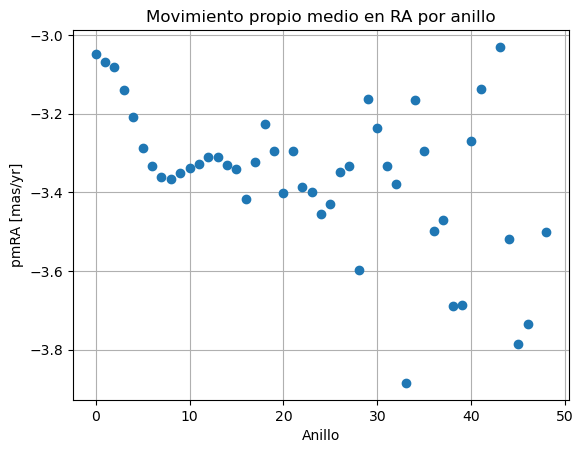

In [35]:
cluster_members_per_ring['pmRA'].plot(
    style='o',
    xlabel='Anillo',
    ylabel='pmRA [mas/yr]',
    title='Movimiento propio medio en RA por anillo',
    grid=True)
plt.show()

## Movimiento propio medio en declinación por anillo

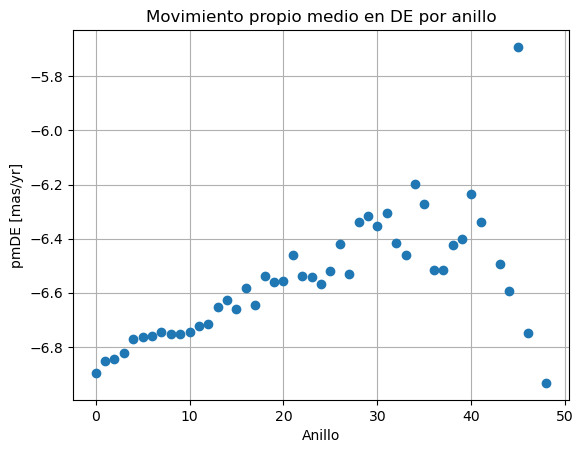

In [36]:
cluster_members_per_ring['pmDE'].plot(
    style='o',
    xlabel='Anillo',
    ylabel='pmDE [mas/yr]',
    title='Movimiento propio medio en DE por anillo',
    grid=True)
plt.show()

## Índice de color medio por anillo

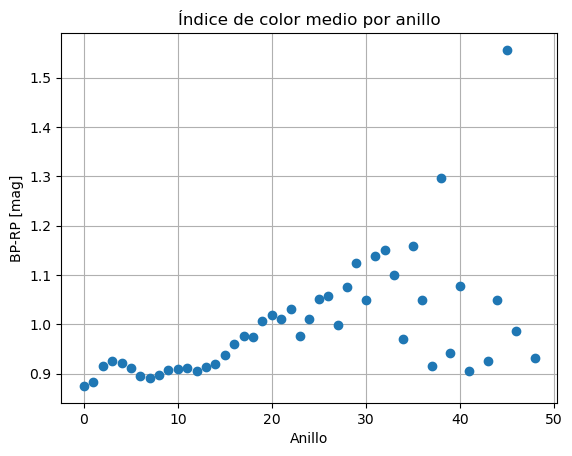

In [37]:
cluster_members_per_ring['BP-RP'].plot(
    style='o',
    xlabel='Anillo',
    ylabel='BP-RP [mag]',
    title='Índice de color medio por anillo',
    grid=True)
plt.show()

## Velocidad radial media por anillo

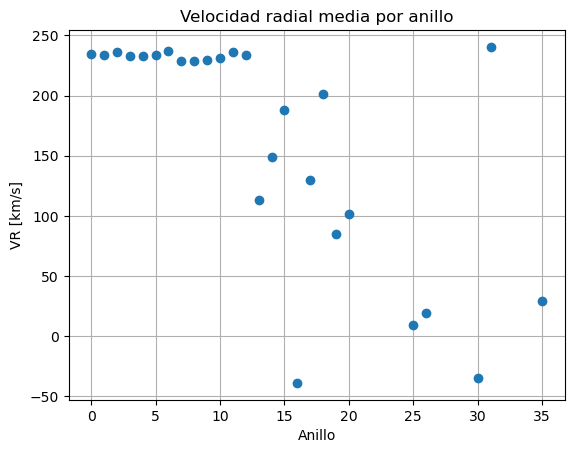

In [38]:
cluster_members_per_ring['RV'].plot(
    style='o',
    xlabel='Anillo',
    ylabel='VR [km/s]',
    title='Velocidad radial media por anillo',
    grid=True)
plt.show()